In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
import torch
import copy
from collections import deque
from random import sample

In [2]:
class DQN:
    def __init__(self, state_size,action_size = 4):
        l1 = state_size
        l2 = 24
        l3 = 24
        l4 = action_size
        self.model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3,l4))

        self.model2 = copy.deepcopy(self.model)
        self.model2.load_state_dict(self.model.state_dict())
        self.loss_fn = torch.nn.MSELoss()
        self.learning_rate = 0.001
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

# The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.
    def update_target(self):
        self.model2.load_state_dict(self.model.state_dict())

# The function "get_qvals" returns a numpy list of qvals for the state given by the argument based on the prediction network.
    def get_qvals(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        qvals_torch = self.model(state)
        q_values = qvals_torch.data.numpy()
        return q_values

# The function "get_maxQ" returns the maximum q-value for the state given by the argument based on the target network.
    def get_maxQ(self,state):
        state_tensor = torch.from_numpy(state).float()  # Convert NumPy array to Tensor
        q_values = self.model(state_tensor)
        return torch.max(q_values).float()

# The function "train_one_step_new" performs a single training step.
# It returns the current loss (only needed for debugging purposes).
# Its parameters are three parallel lists: a minibatch of states, a minibatch of actions,
# a minibatch of the corresponding TD targets and the discount factor.
    def train_one_step(self, states, actions, targets):
        targets_reply = []
        state1_batch = torch.cat([torch.from_numpy(s).float() for s in states])
        action_batch = torch.Tensor(actions)
        Q1 = self.model(state1_batch)
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
        Y = torch.tensor(targets).float()
        loss = self.loss_fn(X, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def save_models(self):
        torch.save(self.model, 'model.pth') 
        torch.save(self.model2, 'model2.pth')

    def load_models(self):
        model = torch.load('model.pth')
        model = torch.load('model2.pth')

In [3]:
class Environment():
    def __init__(self, n):
        self.n = n
        self.elements = {
            'target': {'position': (n-1, 0)},
            'item': {'position': (0, n-1)}
        }
        self.fix_target = False
        self.is_done = False
        self.agent_with_packet = set() # set of agent ID of the agents that has the packet
   

    def set_position(self):
        """Sets a position of any element on the grid without overlapping with others"""
        position = np.random.randint(0, self.n), np.random.randint(0, self.n)

        taken_positions = [element['position'] for element in self.elements.values()] # Position of elements cannot overlap

        while position in taken_positions:
            position = np.random.randint(0, self.n), np.random.randint(0, self.n)

        return position

    def get_grid_size(self):
        """Returns: int n which means the environment is a grid of shape nxn"""
        return self.n


    def reset_grid(self):
        '''Resets the position of the given agent and the item, and item_picked is set to False'''
        self.is_done = False
        self.agent_with_packet.clear()
        for agent_id in  [elem for elem in self.elements if elem != 'target' and elem != 'item']: 
            self.elements[agent_id]['position']  = self.set_position()
            self.elements[agent_id]['has_item'] = False
            self.elements[agent_id]['is_done'] = False


    def add_agent_to_env(self, type):
        """Adds an agent to the grid by initialising its position(tuple).
        Creates and agent_id and stores {agent_id: position} as {key:value} in self.agents
        Returns: agent_id (int)
        """
        agent_id = len([ elem for elem in self.elements if elem !='target' and elem != 'item'])+1

        self.elements[agent_id] = {
            'position': self.set_position(),
            'has_item': False,
            'type': type,
            'is_done': False
        }


        return agent_id

    def get_position (self, element_key):
        """ Returns: tuple with (x,y) position for the element"""
        element = self.elements.get(element_key)
        position = element.get('position')
        return position



    def change_agent_position(self, agent_id, action):
        """ Given the action the agent wants to take, it updates the position for the agent.
        If the agent tries to move outside the grid, the position remains the same.
        This method returs True if the agent picked the item in this step and None otherwise.
        """
        agent = self.elements[agent_id]

        #Get agent position
        (Xa,Ya) = agent['position']

        new_position = None

        #Allow move if it kees agent inside the grid and store new position
        if action == "up" and Ya < self.n - 1:
            new_position = (Xa , Ya + 1)
        elif action == "down" and Ya > 0:
            new_position = (Xa , Ya - 1)
        elif action == "left" and Xa > 0:
            new_position = (Xa - 1 , Ya)
        elif action == "right" and Xa < self.n - 1:
            new_position = (Xa + 1 , Ya)       
        else:
            new_position = (Xa,Ya)

        #Update agent position
        self.elements[agent_id]['position']  = new_position

    def calculate_manhattan_distance(self, agent_type, position):
        (xa, ya) = position
        if agent_type == 'A':
            (xo, yo) = self.get_position('item')
        else: 
            (xo, yo) = self.get_position('target')
        
        return abs(xo - xa) + abs(yo - ya)


    def calculate_reward(self, agent, current_state, next_state):
        """Calculate reward based on agent's actions and state transitions.
        Returns reward value
        """
        # print(f'CalcRew: Agent{agent.id}: {agent}')
        # print(current_state)
        # print(next_state)
        reward = -1

        if  np.all(current_state[:(self.n*self.n+1)] == next_state[:(self.n*self.n+1)]): # The agent tried to go off the grid 
            reward += -20 # Negative Reward for trying to go off the grid
        elif agent.handover == True: # Successfull handover
            reward += 80
            d = self.calculate_manhattan_distance(agent.agent_type, agent.get_position())
            reward += -(d**2) #TODO:  this has to calculate the Mahattan distance to the item for Agent1 
        elif agent.agent_type == 'A' and agent.pickup == True: # The agent picked up the item
            reward += 20
        elif agent.agent_type == 'B' and agent.deliver == True: # The agent delivered the item
            reward += 200

        # print(f'REWARD: {reward}')
        return reward

            

    def get_one_hot_encoding(self,position):
        grid_size = self.get_grid_size()
        num_options= grid_size**2
        x, y = position  # Unpack the tuple (X, Y)
        index = x * grid_size + y  # Convert (X, Y) into a single index
        one_hot = np.zeros(num_options)
        one_hot[index] = 1
        return one_hot
    
    def get_state(self, agent_id):

        #TODO: for the moment being, I'm leaving the agent of the same type. Still to analyse if it is required.
        if agent_id == 1:
            state_order = [1,2,3,4]
        elif agent_id == 2:
            state_order = [2,1, 3,4]
        if agent_id == 3:
            state_order = [3,4,1,2]
        elif agent_id == 4:
            state_order = [4,3,1,2]
        
        state = []

        for agent_id in  state_order: 
            agent = self.elements[agent_id]
            agent_ohe = self.get_one_hot_encoding(agent['position'])
            has_item = np.array([1]) if agent['has_item'] else np.array([0])
            state = np.concatenate([state, agent_ohe, has_item])
            
        return state
    
    def visualize(self):
        """Nice visualisation of environment"""

        colors = ['red','darkred','darkblue','mediumblue']
        item_position = self.get_position('item')
        target_position = self.get_position('target')

        def get_index(position):
            x, y = position
            index = x * self.n + y
            return index
        
        item_index = get_index(item_position)
        target_index = get_index(target_position)
        

        _, ax = plt.subplots(figsize=(2, 2))
        for i in range(self.n):
            for j in range(self.n):
                ax.add_patch(patches.Rectangle((i, j), 1, 1, fill=True, color='lightgray'))
        ax.add_patch(patches.Rectangle(target_position, 1, 1, fill=True, color='green', label=f'Target({target_position},{target_index})'))

        for agent in [elem for elem in self.elements if elem != 'target' and elem != 'item']:
            agent_position = self.get_position (agent)
            agent_index = get_index(agent_position)
            agent_type = self.elements[agent]['type']
            if agent_type == 'A':
                ax.add_patch(patches.Circle((agent_position[0]+ 0.5, agent_position[1] + 0.5), 0.2, fill=True, color=colors[int(agent)-1], label=f'Agent{agent}{agent_type} ({agent_position},{agent_index})'))
                ax.text(agent_position[0] + 0.4, agent_position[1] + 0.4, str(f'{agent}{agent_type}'), ha='right', va='top', color='black', fontsize=6)
            else:
                ax.add_patch(patches.Circle((agent_position[0]+ 0.5, agent_position[1] + 0.5), 0.14, fill=True, color=colors[int(agent)-1], label=f'Agent{agent}{agent_type} ({agent_position},{agent_index})'))
                ax.text(agent_position[0] + 0.4, agent_position[1] + 0.4, str(f'{agent}{agent_type}'), ha='right', va='top', color='black', fontsize=6)
                
        ax.add_patch(patches.Circle((item_position[0] + 0.5, item_position[1] + 0.5), 0.07, fill=True, color='darkviolet', label=f'Item({item_position},{item_index})'))
            
        for agent_id in self.agent_with_packet:
            agent_with_packet_position = self.get_position(agent_id)
            ax.add_patch(patches.Circle((agent_with_packet_position[0] + 0.5, agent_with_packet_position[1] + 0.5), 0.07, fill=True, color='deeppink'))
            

        ax.legend()
        ax.set_xlim(0, self.n)
        ax.set_ylim(0, self.n)
        ax.set_aspect('equal')
        plt.xticks(np.arange(0, self.n + 0.5))
        plt.yticks(np.arange(0, self.n + 0.5))
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        plt.grid()
        plt.show()

    def visualize_text(self):
        # Define the grid size
        grid_size = self.get_grid_size()


        # Create an empty grid
        grid = [['  ' for _ in range(grid_size)] for _ in range(grid_size)]

        
        grid[0][grid_size-1] = 'Tg'
        grid[grid_size-1][0] = 'It'


        print ('--------------------------------')
        # Place elements on the grid
        for agent_id in [elem for elem in self.elements if elem != 'target' and elem != 'item']:
            agent = self.elements[agent_id]
            
            x, y = agent['position']
            # print(f'Agent{agent} ')

            if agent['has_item']:
                grid[y][x] = str(agent_id)+'●'
            else:
                grid[y][x] = str(agent_id)+' '


        grid = grid[::-1]

        # Define the cell separator
        separator = '+----' * (grid_size) + '+'

        # Print the grid with separators
        for row in grid:
            print(separator)
            print('| ' + ' | '.join(row) + ' |')

        # Print a final separator for the bottom
        print(separator)

        print ('--------------------------------')



In [6]:
# sqw = SquareGridWorld(grid_size=5, no_a_agents=2, no_b_agents=2)
# sqw.env.visualize_text()

In [4]:
class DeepQAgent:
    def __init__(self, env, dqn, agent_type):
        self.env = env
        self.dqn = dqn
        self.agent_type = agent_type
        self.id = self.env.add_agent_to_env(agent_type)
        if agent_type == 'A':
            self.pickup = False
            self.handover = False
        else:
            self.handover = False
            self.deliver = False
   
    def get_position(self):
        return self.env.elements[self.id]['position']
   
    def is_done(self):
        return self.env.elements[self.id]['is_done']
    
    def has_item(self):
        return self.env.elements[self.id]['has_item']
    
    def set_is_done(self, value):
        self.env.elements[self.id]['is_done'] = value
    
    def set_has_item(self, value):
        self.env.elements[self.id]['has_item'] = value

    def select_action(self, current_state, exploration_proba=1):
        '''Select what action will each agent take given the current state of the environment'''
        # The following if-else statement determines if the agent will take a random exploratory
        # action or the max q action
        if np.random.rand() < exploration_proba:
            action_index = np.random.randint(4) # Select a random action (exploration)
        else:
            action_index = np.argmax(self.dqn.get_qvals(current_state)) # Select best action based on q values
        
        return action_index
      
    def move(self, action_index):
        action = ['up','down','right','left'][action_index]
        self.env.change_agent_position(self.id, action)
        return action



    def get_state(self):
        return self.env.get_state(self.id)
    
    def fill_replay_buffer(self, replay_buffer_size=1000):

        self.replay_buffer = deque(maxlen=replay_buffer_size) # Collect experiences
        for index in range(replay_buffer_size): 
            self.env.reset_grid()         
            current_state = self.get_state()

            # Choose an action and move in the environment
            action_index = self.select_action(current_state) # Only takes random actions when filling the buffer
            action = self.move(action_index) 

            # Get the next state after taking action
            next_state = self.get_state()

            # Calculate reward based on the action chosen
            reward = self.env.calculate_reward(self, current_state, next_state)
            
            # Adding noise to avoid dead neurons
            noise = np.random.rand(1,len(current_state))/1000000
            current_state_with_noise = current_state + noise
            next_state_with_noise = next_state + noise
            
            # Add experience to replay buffer
            self.replay_buffer.append([current_state_with_noise, action_index,reward,next_state_with_noise,self.is_done()])

    def add_experience(self, current_state, action,reward,next_state):
        # Adding noise to avoid dead neurons
        noise = np.random.rand(1,len(current_state))/1000000
        current_state_with_noise = current_state + noise
        next_state_with_noise = next_state + noise
        is_done = self.is_done()
        # Add experience to replay buffer
        self.replay_buffer.append([current_state_with_noise, action,reward,next_state_with_noise,is_done])

        #Resets is_done so the agent can start another task
        if is_done: self.set_is_done(False)


        
    def pick_handover_deliver(self):    

        # print(f'Agents with packets : {self.env.agent_with_packet}')
        # print(f'Agents id : {self.id} {self.has_item()}')
        if (self.agent_type == 'A'):
            self.pickup = False
        else:
            self.deliver = False
        self.handover = False
        
        #PICK
        if (self.agent_type == 'A') and (not self.has_item()) and (self.get_position() == self.env.elements['item']['position']):
            self.pickup = True
            self.handover = False
            self.set_has_item(True) 
            self.env.agent_with_packet.add(self.id)
            # return DONT RETURN TO ALLOW TO PICK AND HANDOVER AT THE SAME STEP 

        #HANDOVER
        if (self.agent_type == 'A') and (self.has_item()):
            for agent_id in [ elem for elem in self.env.elements if elem !='target' and elem != 'item']:
                agent = self.env.elements[agent_id]
                if (agent['type'] == 'B') and (agent['has_item'] == False) and (agent['position'] == self.get_position()):
                    self.pickup = False
                    self.handover = True
                    self.set_has_item(False)
                    self.set_is_done(True)
                    # print (f'BEFORE: {self.env.agent_with_packet}')
                    self.env.agent_with_packet.remove(self.id)
                    self.env.agent_with_packet.add(agent_id) # Flags the handover to agent B
                    # print (f'AFTER: {self.env.agent_with_packet}')
                    return 0
        if (self.agent_type == 'B') and (self.env.elements[self.id]['has_item'] == False) and (self.id in self.env.agent_with_packet):
                    self.handover = True
                    self.set_has_item(True)
                    return 0

        #DELIVER
        if (self.agent_type == 'B') and (self.env.elements[self.id]['has_item'] == True) and (self.get_position() == self.env.elements['target']['position']):
            self.env.is_done = True
            self.deliver = True
            self.set_has_item(False)
            self.set_is_done(True)
            self.env.agent_with_packet.remove(self.id)
            # print('Delivery done!')
            return 1
        

        return 0

    def minibatch_to_lists(self, discount_factor, batch_size=200):
        minibatch = sample(self.replay_buffer, batch_size)
        mb_states, mb_actions, mb_targets, mb_rewards = [],[],[],[]

        for experience in minibatch:
            current_state, action,reward,next_state,is_done = experience # Unpacking
            
            # Calculate the maximum Q-value for the next state
            if not is_done:   
                max_next_q_value = self.dqn.get_maxQ(next_state)
            else:
                max_next_q_value = 0

            # Adding data to lists
            mb_states.append(current_state)
            mb_actions.append(action)
            td_target = reward + discount_factor * max_next_q_value
            mb_targets.append(td_target)
            mb_rewards.append(reward)

        return mb_states, mb_actions, mb_targets, mb_rewards
        


    def update_dqn(self, discount_factor, batch_size=200):
        mb_states, mb_actions, mb_targets, _ = self.minibatch_to_lists(discount_factor, batch_size)
        loss = self.dqn.train_one_step(mb_states, mb_actions, mb_targets)
        # print('training DQN...')

    def update_target(self):
        # print('updating target...')
        self.dqn.update_target()

    def __str__(self):
        if self.agent_type =='A':
            return f"Agent{self.id}{self.agent_type}:\n\tPosition: {self.get_position()}\n\tPickup: {self.pickup}\n\tHandover: {self.handover}\n\tHas Item: {self.env.elements[self.id]['has_item']}"
        else:
            return f"Agent{self.id}{self.agent_type}:\n\tPosition: {self.get_position()}\n\tDeliver: {self.deliver}\n\tHandover: {self.handover}\n\tHas Item: {self.env.elements[self.id]['has_item']}"



In [8]:
# sgw.agents[0].minibatch_to_lists(discount_factor=1)

In [8]:
from tqdm import trange
class SquareGridWorld:

    def __init__(self, grid_size=4, no_a_agents=2, no_b_agents=2) :
        self.grid_size = grid_size
        self.no_a_agents=no_a_agents
        self.no_b_agents=no_b_agents
        self.no_agents = no_a_agents + no_b_agents
        # Create environment
        self.env = Environment(grid_size)
        
        self.state_size = (grid_size**2+1) * self.no_agents#state size is compose for grid_size**2(position) + 1(has item) by the total number of agents in the system
        # Create DQN for type A agents
        self.dqn_a = DQN(state_size=self.state_size)

        # Create DQN for type B agents
        self.dqn_b = DQN(state_size=self.state_size) 

        # Initialize list of agents
        self.agents = []

        #DONE: pass dqn instance as a parameter
        for _ in range(no_a_agents):
            self.agents.append(DeepQAgent(self.env, self.dqn_a, agent_type='A')) 

        for _ in range(no_b_agents):  
            self.agents.append(DeepQAgent(self.env, self.dqn_b, agent_type='B'))



    def train_multiagents(self, episodes = 1000, max_steps = 100, learning_rate=0.1, discount_factor=0.8, exploration_proba=1, exploration_decay=0.001,
                            min_exploration_proba=0.01, update_frequency=500, replay_buffer_size=1000, batch_size=200):
        
        # ---------------------------------------------------------------------------------------------------------------------
        # INITIALISATION
        # ---------------------------------------------------------------------------------------------------------------------
    
        training_loss = [] # Stores the loss for every minibatch
        c=1  # Counter to know when to update TARGET DNN    
        
        
        deliveries_per_episode = [] # Stores the number of deliveries for every episode
        rewards_per_episode = []

        # ---------------------------------------------------------------------------------------------------------------------
        # SAMPLING PHASE. Get experiences to fill replay buffer
        # ---------------------------------------------------------------------------------------------------------------------
        for agent in self.agents:
            agent.fill_replay_buffer(replay_buffer_size)

        # print('AGENTS REPLAY BUFFER HAVE BEEN FILLED')

        # # ---------------------------------------------------------------------------------------------------------------------
        # # LEARNING PHASE
        # # ---------------------------------------------------------------------------------------------------------------------
        # # startime = datetime.now()
        
        for episode in trange(episodes):
            
            exploration_proba = max(min_exploration_proba, exploration_proba*np.exp(-exploration_decay*episode))
            
            #Reset environment
            self.env.reset_grid()
            for agent in self.agents:  #--> THIS COULD PROBABLY BE AT RESET ENVIRONMENT
                agent.set_is_done(False)


            # TODO: Initialize current state after grid reset
            current_states = [ self.env.get_state(agent.id) for agent in self.agents]
            

            episode_deliveries = 0 # Used to count delivered packets in the episode
            episode_reward = 0
            # print('#################################################################')
            # print(f'EPISODE {episode}')
            for step in range(max_steps):

                #NEW EXPERIENCE
        #         if episode in [0,500,999]:
                # print('-----------------------------------------------------------')
                # print(f'EPISODE {episode} step {step}')
                # print('-')
                # self.env.visualize()

                # self.env.visualize_text()

                # Choose an action for each agent
                action_indexes = [agent.select_action(state, exploration_proba) for agent, state in zip(self.agents, current_states)]

                # Move agents in environment based on choosen action
                actions = [agent.move(action_index)  for agent, action_index in zip(self.agents, action_indexes)]
                # print(actions)

                # Define if items have been picked, handed over or delivered
                episode_deliveries +=  np.sum([agent.pick_handover_deliver() for agent in self.agents ])  
                
                # self.env.visualize_text()
                # print('-')

                next_states = [ self.env.get_state(agent.id) for agent in self.agents]
             
                rewards = [self.env.calculate_reward(agent, current_state, next_state) for agent, current_state, next_state in zip(self.agents, current_states, next_states) ]

                # print(rewards)   
                episode_reward +=  np.sum(rewards)  

                # [print(agent) for agent in self.agents]

                [agent.add_experience(current_state, action,reward,next_state) for agent,current_state, action,reward,next_state in zip(self.agents, current_states,action_indexes,rewards,next_states)]

                current_states = next_states 

                if step % 10 == 0: # Every 10 experiences the dqns get updated
                    [agent.update_dqn(discount_factor, batch_size) for agent in self.agents]

                c += 1
                if c % update_frequency == 0: # Update target every update_frequency
                    [agent.update_target() for agent in self.agents]

            # print(f'TOTAL DELIVERIES: {episode_deliveries}')    
            deliveries_per_episode.append(episode_deliveries)
            rewards_per_episode.append(episode_reward) 
        
        fig, axs = plt.subplots(2, 1)
        axs[0].set_title('Episodes Deliveries')
        axs[0].plot(deliveries_per_episode)
        axs[1].set_title('Episodes Rewards')
        axs[1].plot(rewards_per_episode)

    def evaluate(self, max_steps=80):

        #Reset environment
        self.env.reset_grid()


        # TODO: Initialize current state after grid reset
        current_states = [ self.env.get_state(agent.id) for agent in self.agents]
        

        episode_deliveries = 0 # Used to count delivered packets in the episode
        episode_reward = 0 

        for step in range(1,max_steps+1):


            self.env.visualize()

            # Choose an action for each agent
            action_indexes = [agent.select_action(state, exploration_proba=0) for agent, state in zip(self.agents, current_states)]

            # Move agents in environment based on choosen action
            actions = [agent.move(action_index)  for agent, action_index in zip(self.agents, action_indexes)]

            # Define if items have been picked, handed over or delivered
            episode_deliveries +=  np.sum([agent.pick_handover_deliver() for agent in self.agents ])  

            next_states = [ self.env.get_state(agent.id) for agent in self.agents]
            
            rewards = [self.env.calculate_reward(agent, current_state, next_state) for agent, current_state, next_state in zip(self.agents, current_states, next_states) ]

            episode_reward +=  np.sum(rewards) 
           
            current_states = next_states 
        print(f'TOTAL DELIVERIES: {episode_deliveries}')
        print(f'TOTAL REWARDS: {episode_reward}')


In [10]:
# sqw = SquareGridWorld(grid_size=4, no_a_agents=2, no_b_agents=2)
# sqw.env.visualize_text()

100%|██████████| 1000/1000 [11:08<00:00,  1.50it/s]


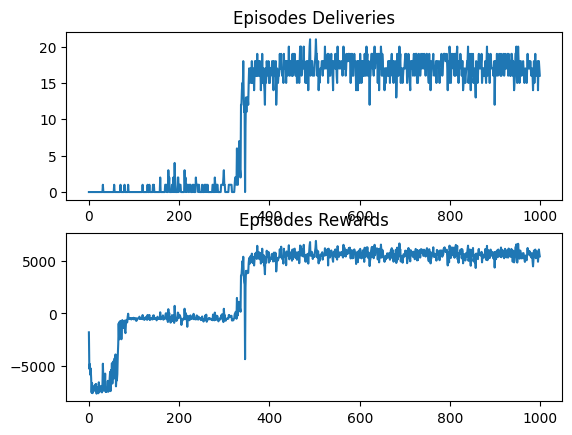

In [9]:
sgw = SquareGridWorld(grid_size=5, no_a_agents=2, no_b_agents=2)
sgw.train_multiagents(episodes=1000, max_steps = 100, learning_rate=0.8, exploration_proba=1, exploration_decay=0.997,
                          min_exploration_proba=0.1, update_frequency=500, replay_buffer_size = 1000, batch_size = 200)

In [10]:
sgw.agents[0].dqn.save_models()
sgw.agents[1].dqn.save_models()
sgw.agents[2].dqn.save_models()
sgw.agents[3].dqn.save_models()

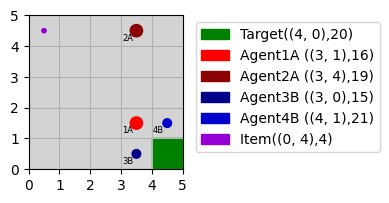

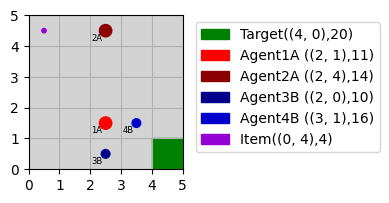

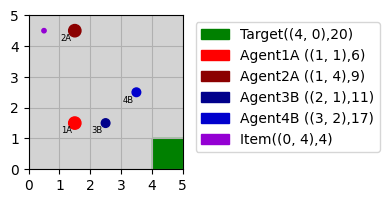

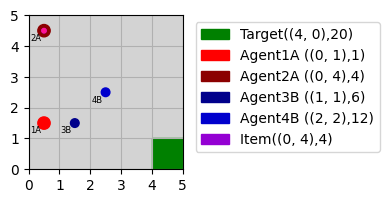

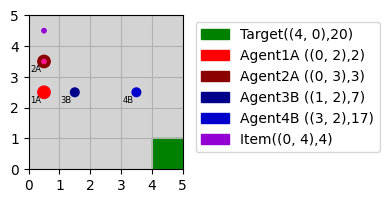

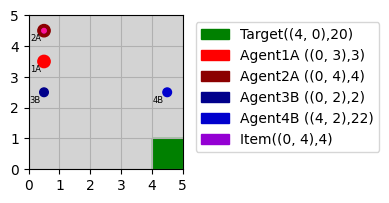

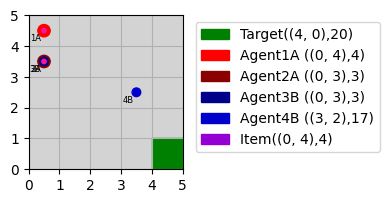

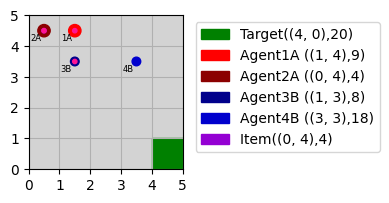

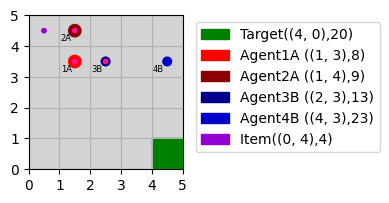

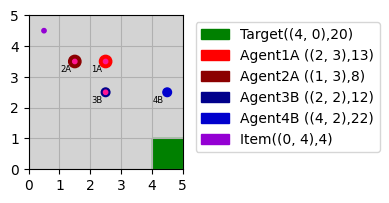

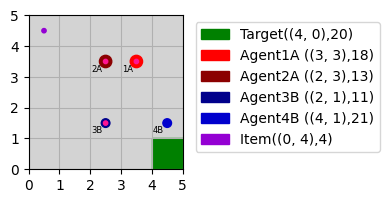

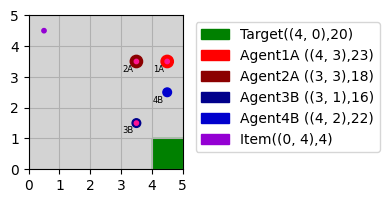

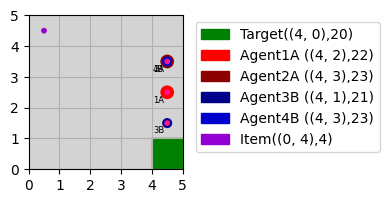

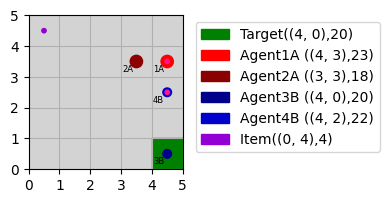

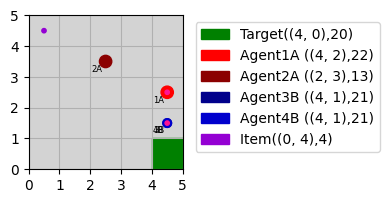

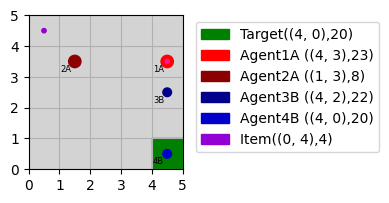

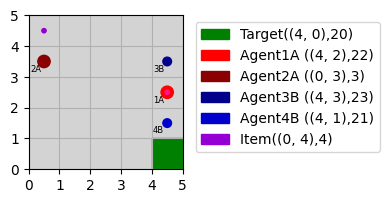

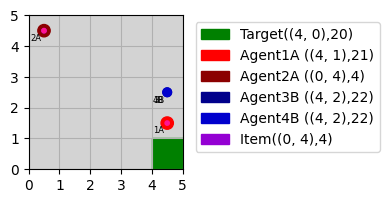

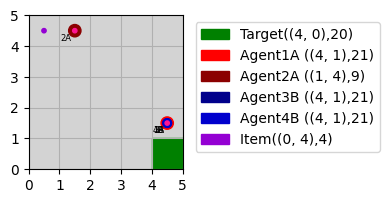

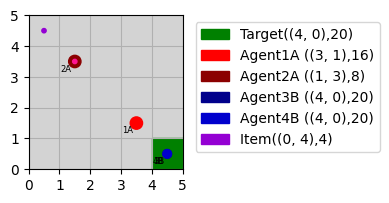

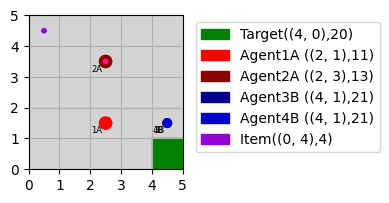

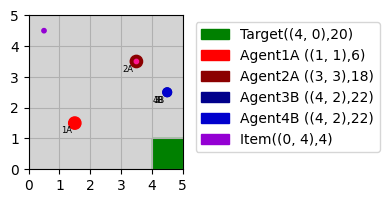

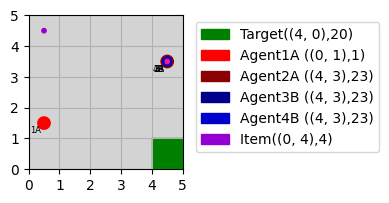

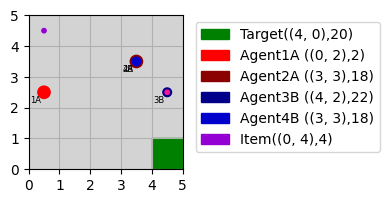

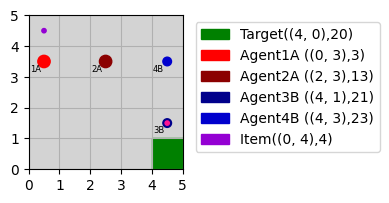

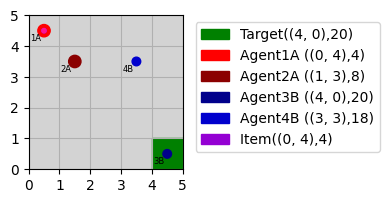

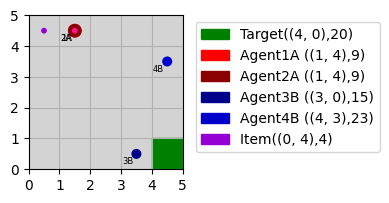

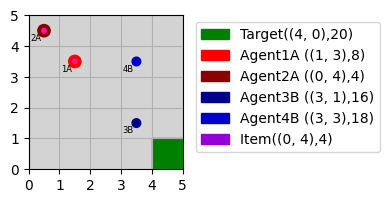

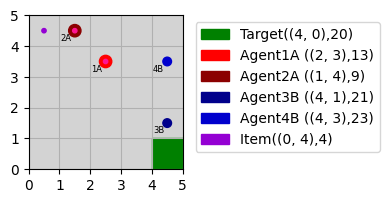

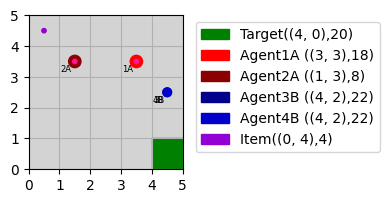

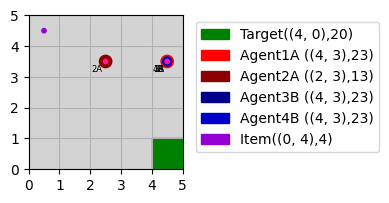

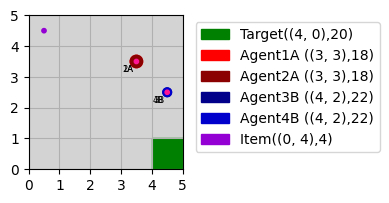

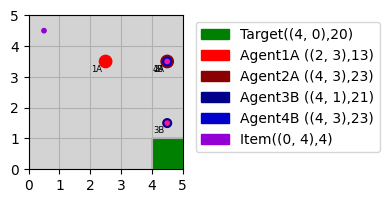

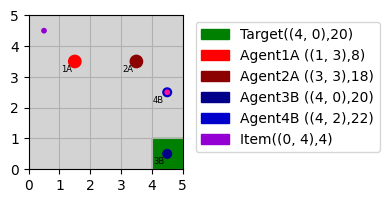

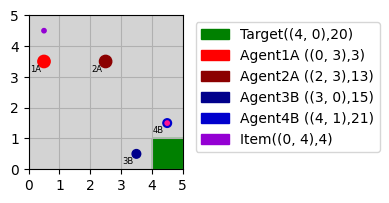

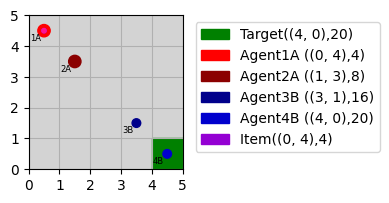

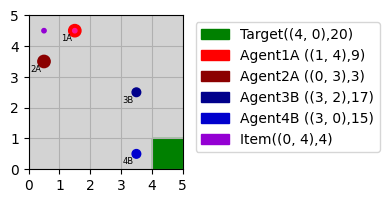

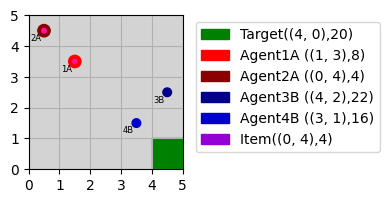

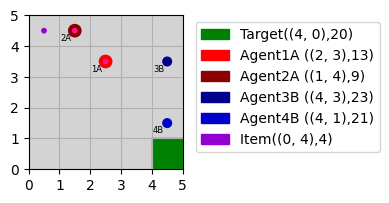

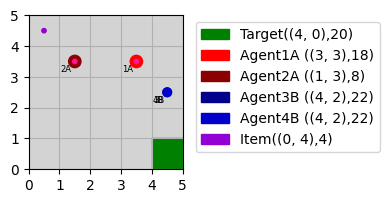

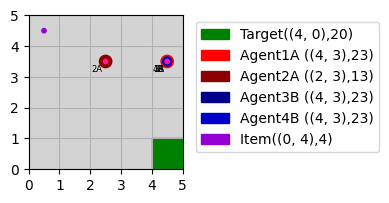

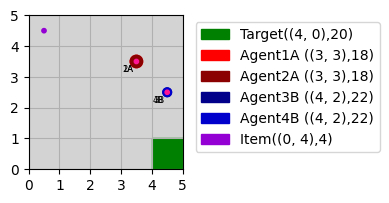

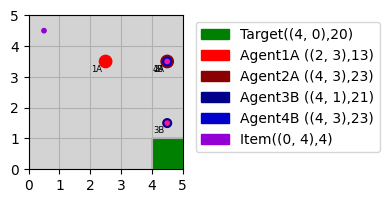

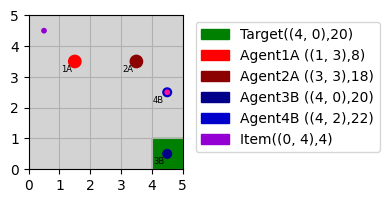

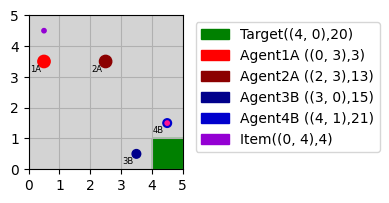

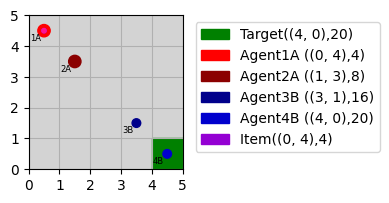

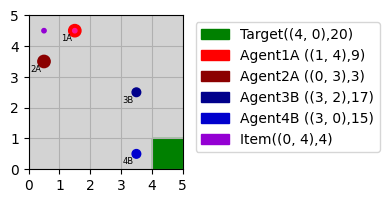

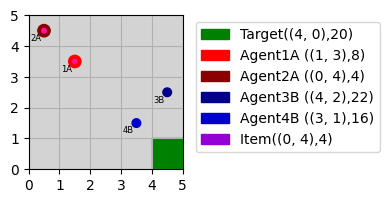

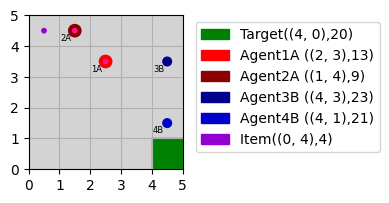

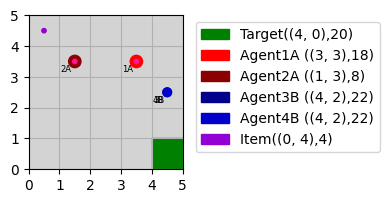

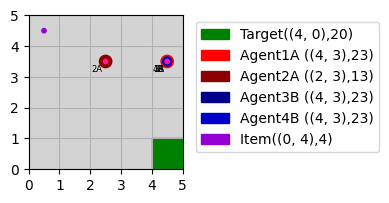

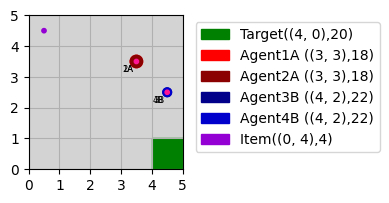

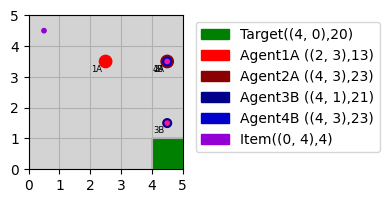

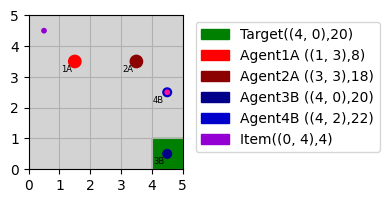

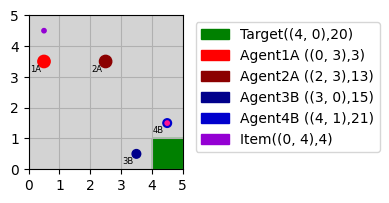

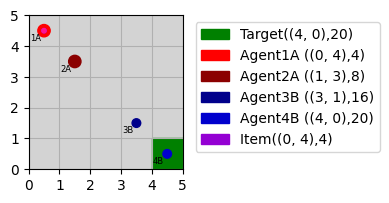

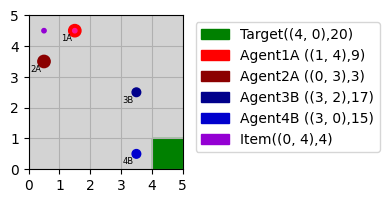

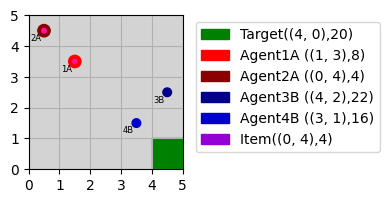

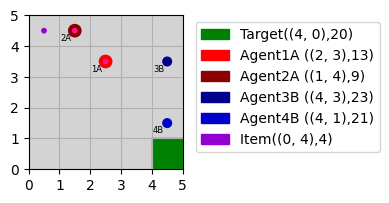

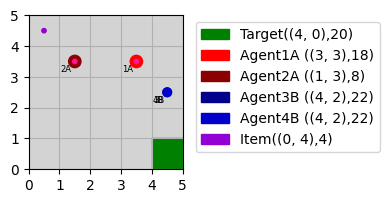

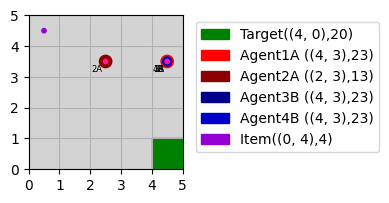

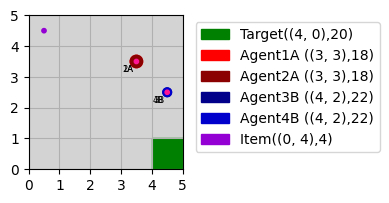

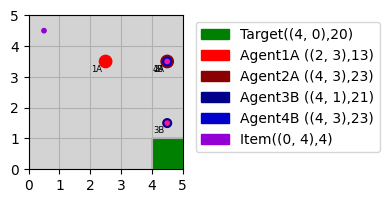

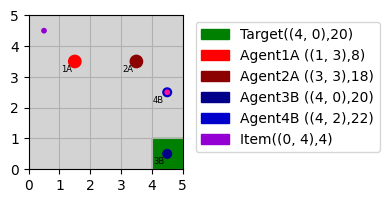

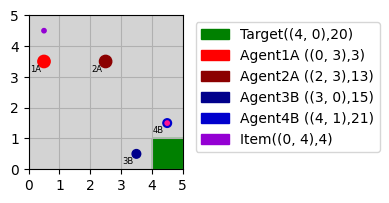

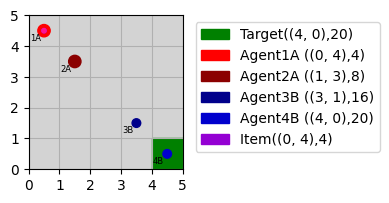

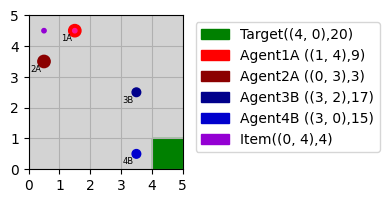

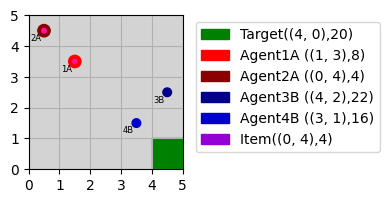

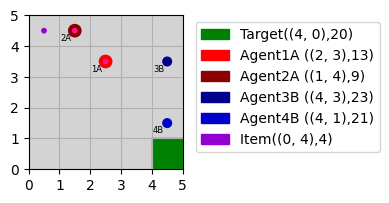

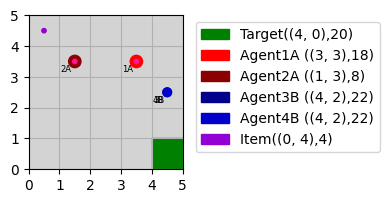

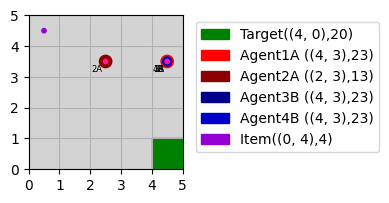

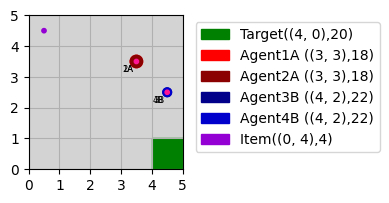

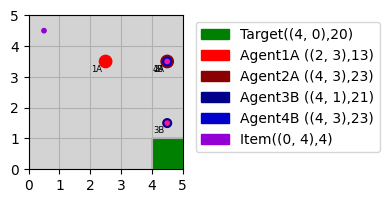

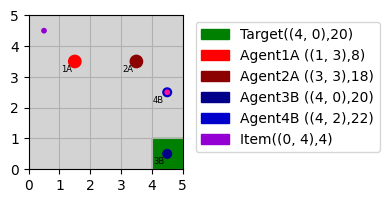

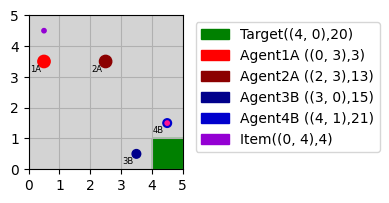

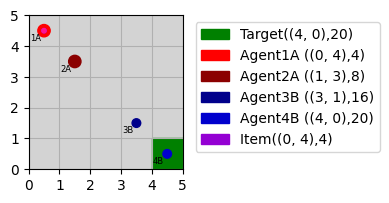

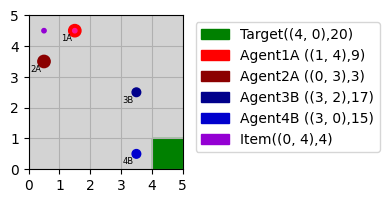

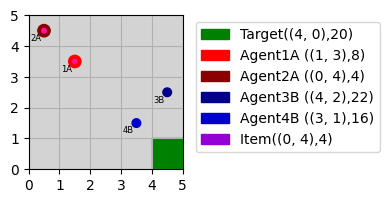

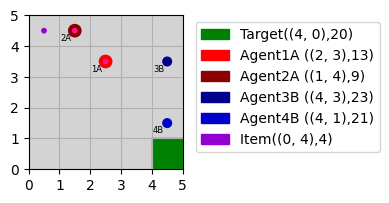

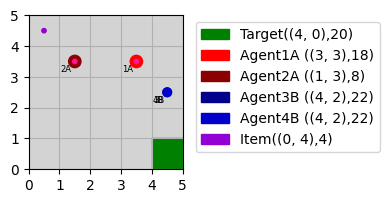

TOTAL DELIVERIES: 14
TOTAL REWARDS: 4658


In [14]:
sgw.evaluate()